# 保险赔偿预测

<img src="images/1.png" alt="FAO" width="590" >


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import cross_val_score

from scipy import stats
import seaborn as sns
from copy import deepcopy

%matplotlib inline

# This may raise an exception in earlier versions of Jupyter
%config InlineBackend.figure_format = 'retina'

在这一部分，我们做一个简短的数据探索，看看我们有什么样的数据集，以及我们是否能找到其中的任何模式。

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 先来瞅瞅数据长啥样

In [4]:
train.shape

(188318, 132)

188k训练实例，132列 数据量还可以。

In [5]:
print ('First 20 columns:', list(train.columns[:20]))

print ('Last 20 columns:', list(train.columns[-20:]))

First 20 columns: ['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19']
Last 20 columns: ['cat112', 'cat113', 'cat114', 'cat115', 'cat116', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'loss']


我们看到，大概有116个种类属性（如它们的名字所示）和14个连续（数字）属性。
此外，还有ID和赔偿。总计为132列。

In [6]:
train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


正如我们看到的，所有的连续的功能已被缩放到[0,1]区间，均值基本为0.5。其实数据已经被预处理了，我们拿到的是特征数据。

### 查看缺失值

绝大多数情况下，我们都需要对缺失值进行处理

In [7]:
pd.isnull(train).values.any()

False

竟然木有缺失值，可以愉快的玩耍了

## Continuous vs caterogical features

Another way to see the division to categorical and continuous features is to run `pd.DataFrame.info` method:

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In here, `float64(15), int64(1)` are our continuous features (the one with `int64` is probably `id`) while `object(116)` are categorical features. We may confirm this:

In [37]:
cat_features = list(train.select_dtypes(include=['object']).columns)
print ('Categorical: {} features'.format(len(cat_features)))
       
       

Categorical: 116 features


In [30]:
cont_features = [cont for cont in list(train.select_dtypes(
                 include=['float64', 'int64']).columns) if cont not in ['loss', 'id']]
print ("Continuous: {} features".format(len(cont_features)))

Continuous: 14 features


In [32]:
id_col = list(train.select_dtypes(include=['int64']).columns)
print ("A column of int64: {}".format(id_col))

A column of int64: ['id']


## 类别值中属性的个数

In [38]:
cat_uniques = []
for cat in cat_features:
    cat_uniques.append(len(train[cat].unique()))
    
uniq_values_in_categories = pd.DataFrame.from_items([('cat_name', cat_features), ('unique_values', cat_uniques)])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """


In [39]:
uniq_values_in_categories.head()

,cat_name,unique_values
0,cat1,2
1,cat2,2
2,cat3,2
3,cat4,2
4,cat5,2


Text(7, 71, 'Binary features')

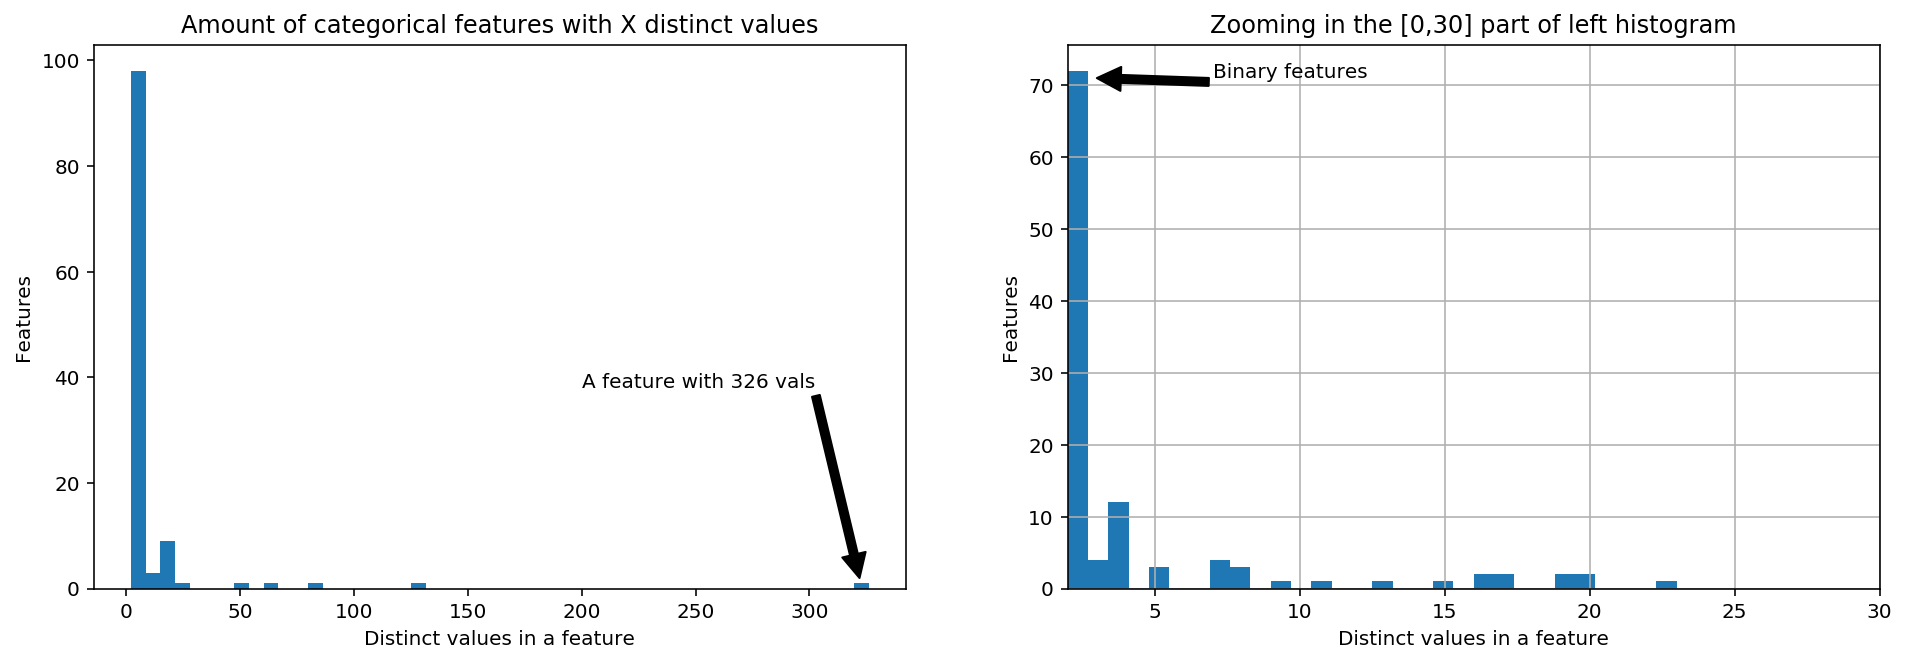

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(uniq_values_in_categories.unique_values, bins=50)
ax1.set_title('Amount of categorical features with X distinct values')
ax1.set_xlabel('Distinct values in a feature')
ax1.set_ylabel('Features')
ax1.annotate('A feature with 326 vals', xy=(322, 2), xytext=(200, 38), arrowprops=dict(facecolor='black'))

ax2.set_xlim(2,30)
ax2.set_title('Zooming in the [0,30] part of left histogram')
ax2.set_xlabel('Distinct values in a feature')
ax2.set_ylabel('Features')
ax2.grid(True)
ax2.hist(uniq_values_in_categories[uniq_values_in_categories.unique_values <= 30].unique_values, bins=30)
ax2.annotate('Binary features', xy=(3, 71), xytext=(7, 71), arrowprops=dict(facecolor='black'))

正如我们所看到的，大部分的分类特征（72/116）是二值的，绝大多数特征（88/116）有四个值，其中有一个具有326个值的特征（一天的数量？）。

## 赔偿值

No handles with labels found to put in legend.


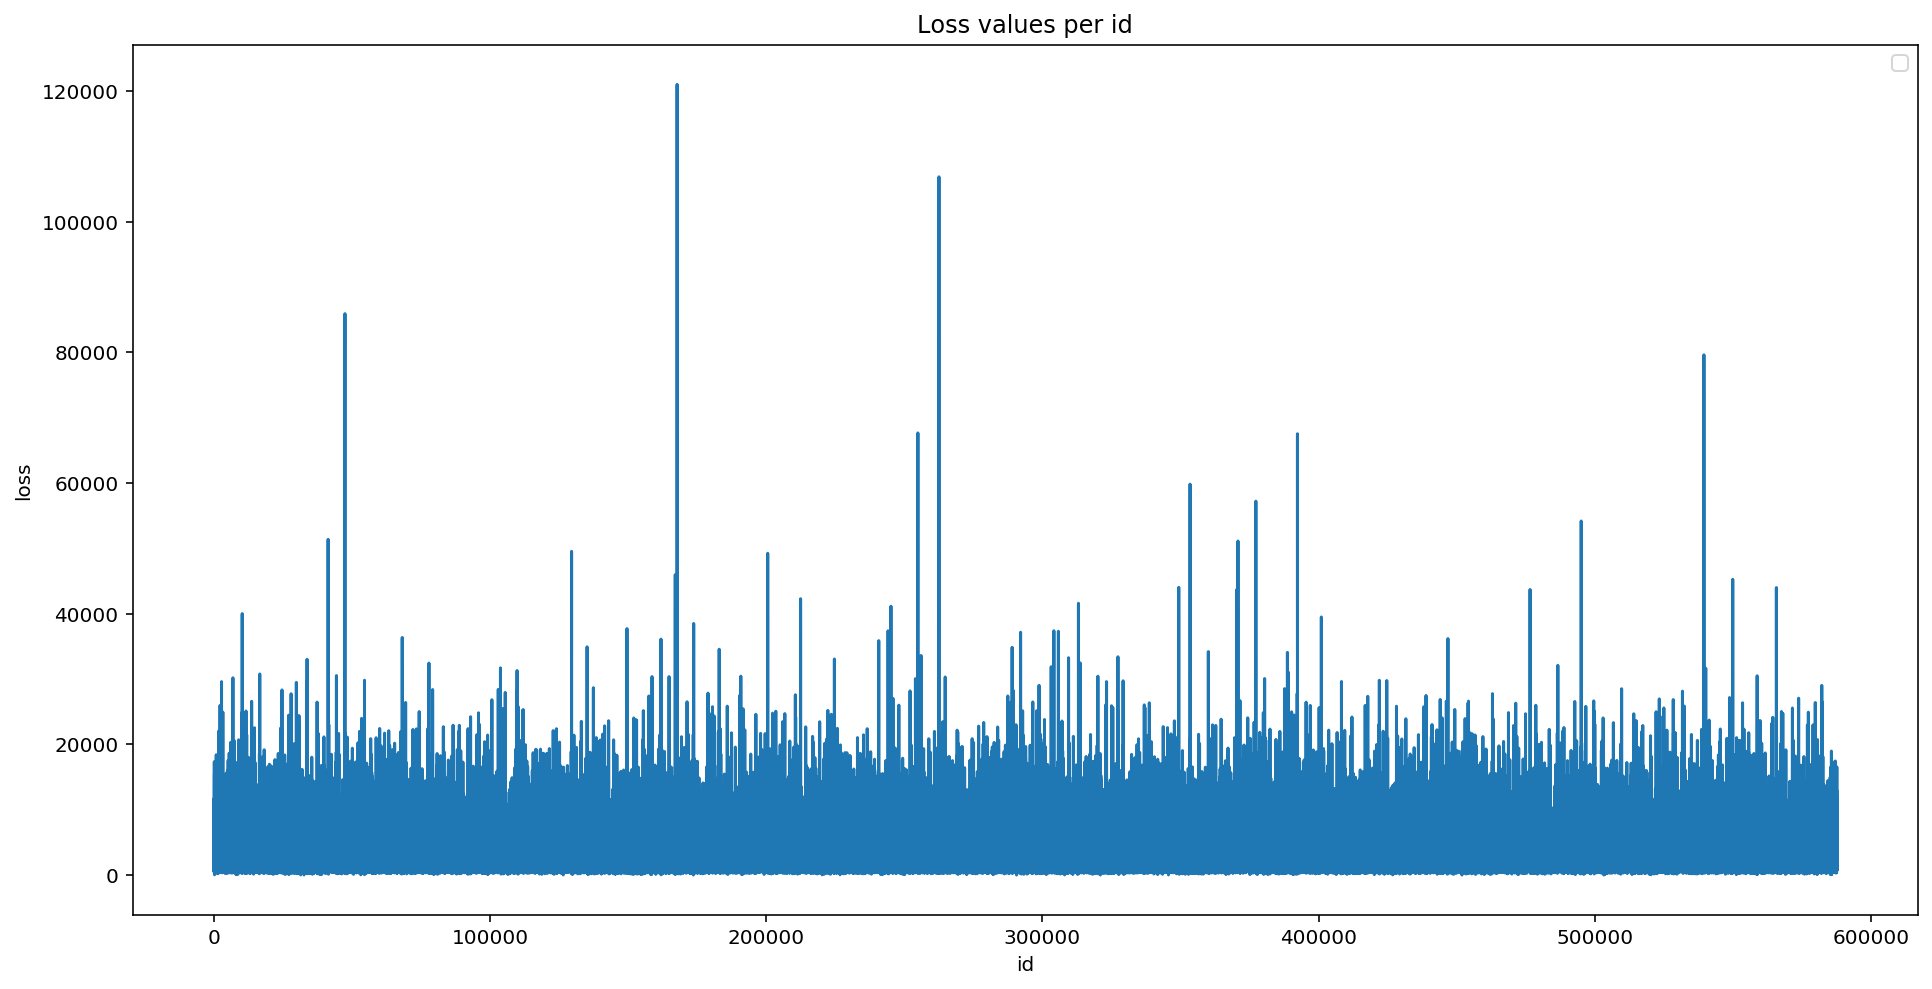

In [41]:
plt.figure(figsize=(16,8))
plt.plot(train['id'], train['loss'])
plt.title('Loss values per id')
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show()

损失值中有几个显著的峰值表示严重事故。这样的数据分布，使得这个功能非常扭曲导致的回归表现不佳。

基本上，偏度度量了实值随机变量的均值分布的不对称性。让我们计算损失的偏度：

In [16]:
stats.mstats.skew(train['loss']).data

array(3.7949281496777445)

数据确实是倾斜的

对数据进行对数变换通常可以改善倾斜，可以使用 `np.log` 

In [17]:
stats.mstats.skew(np.log(train['loss'])).data

array(0.0929738049841997)

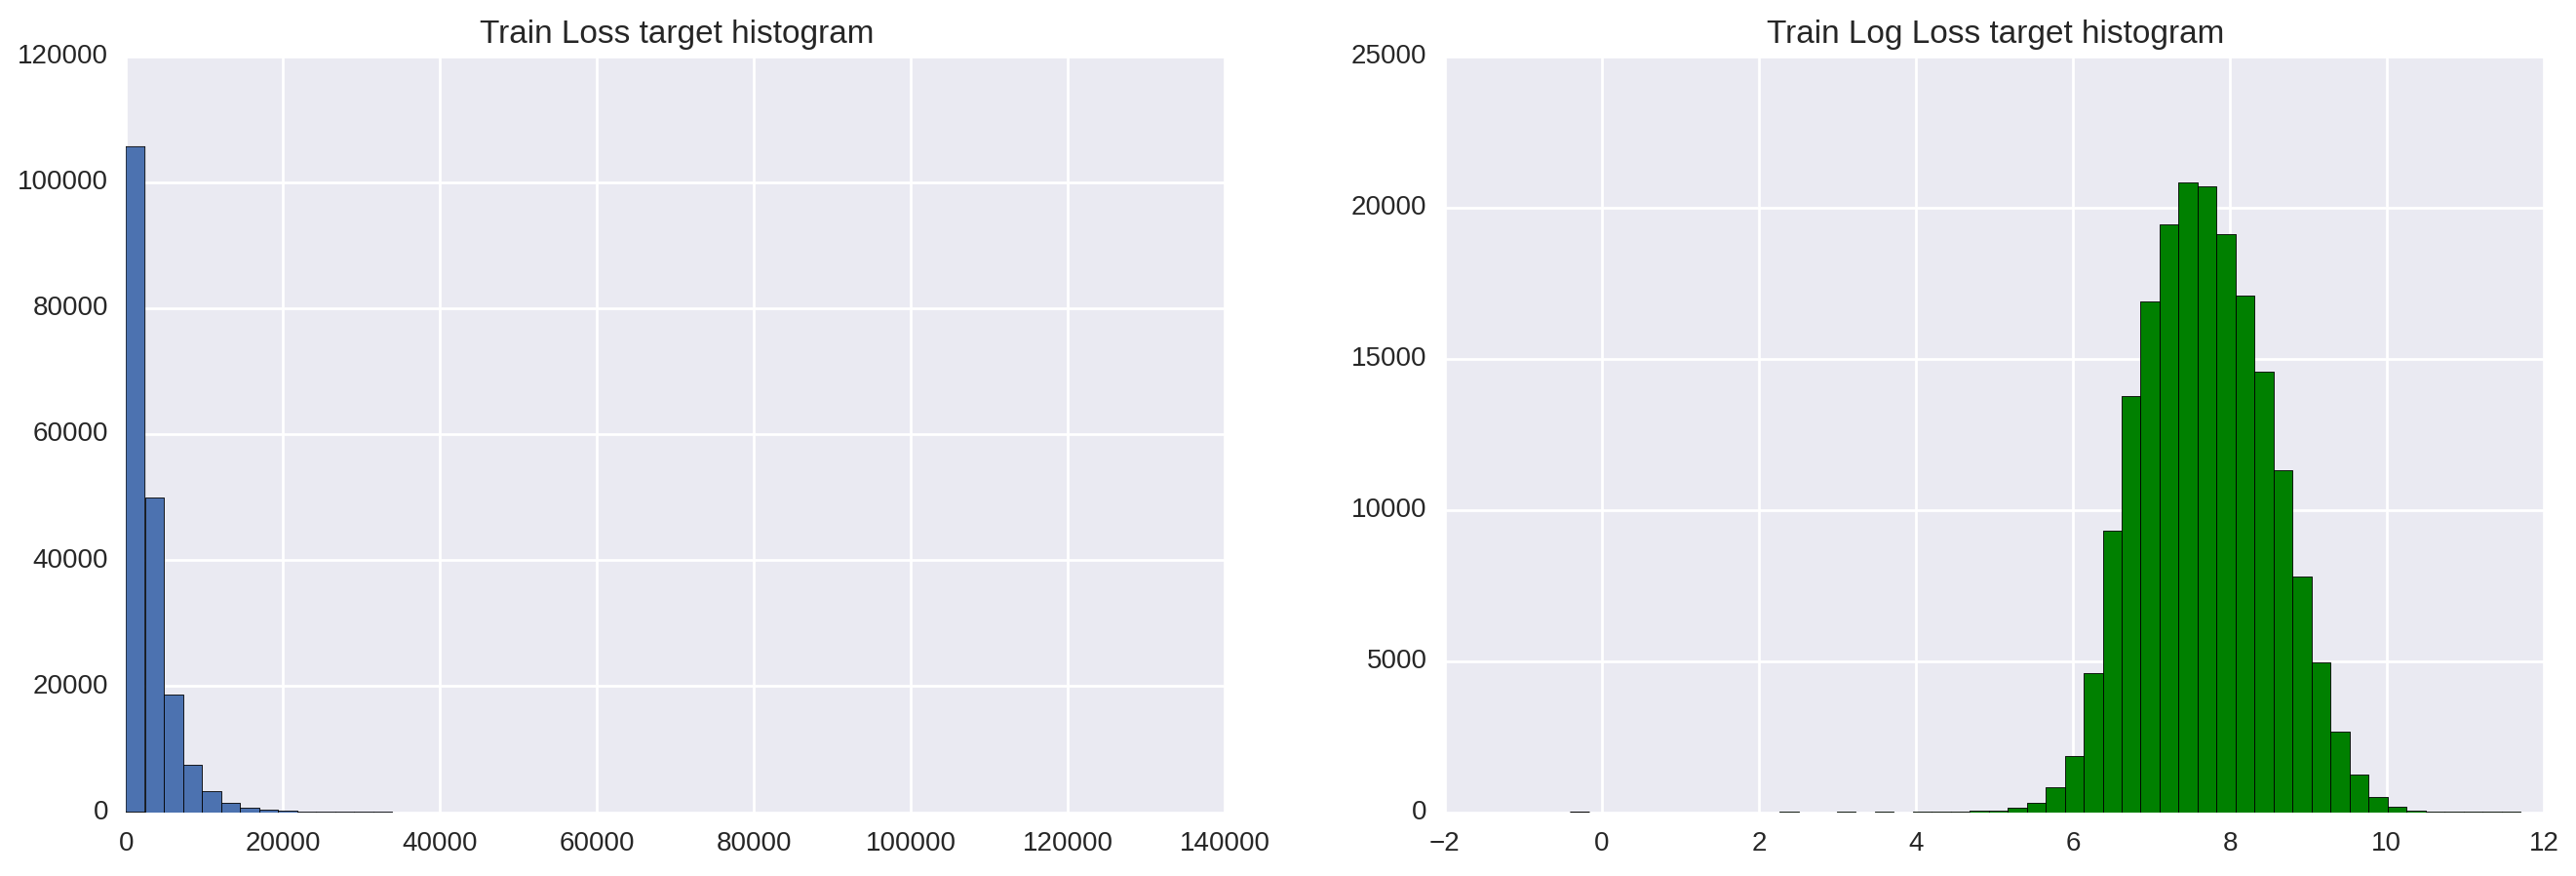

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(train['loss'], bins=50)
ax1.set_title('Train Loss target histogram')
ax1.grid(True)
ax2.hist(np.log(train['loss']), bins=50, color='g')
ax2.set_title('Train Log Loss target histogram')
ax2.grid(True)
plt.show()

## 连续值特征

One thing we can do is to plot histogram of the numerical features and analyze their distributions:

array([[<matplotlib.axes.AxesSubplot object at 0x7ff54a214b10>,
        <matplotlib.axes.AxesSubplot object at 0x7ff530cf6350>]], dtype=object)

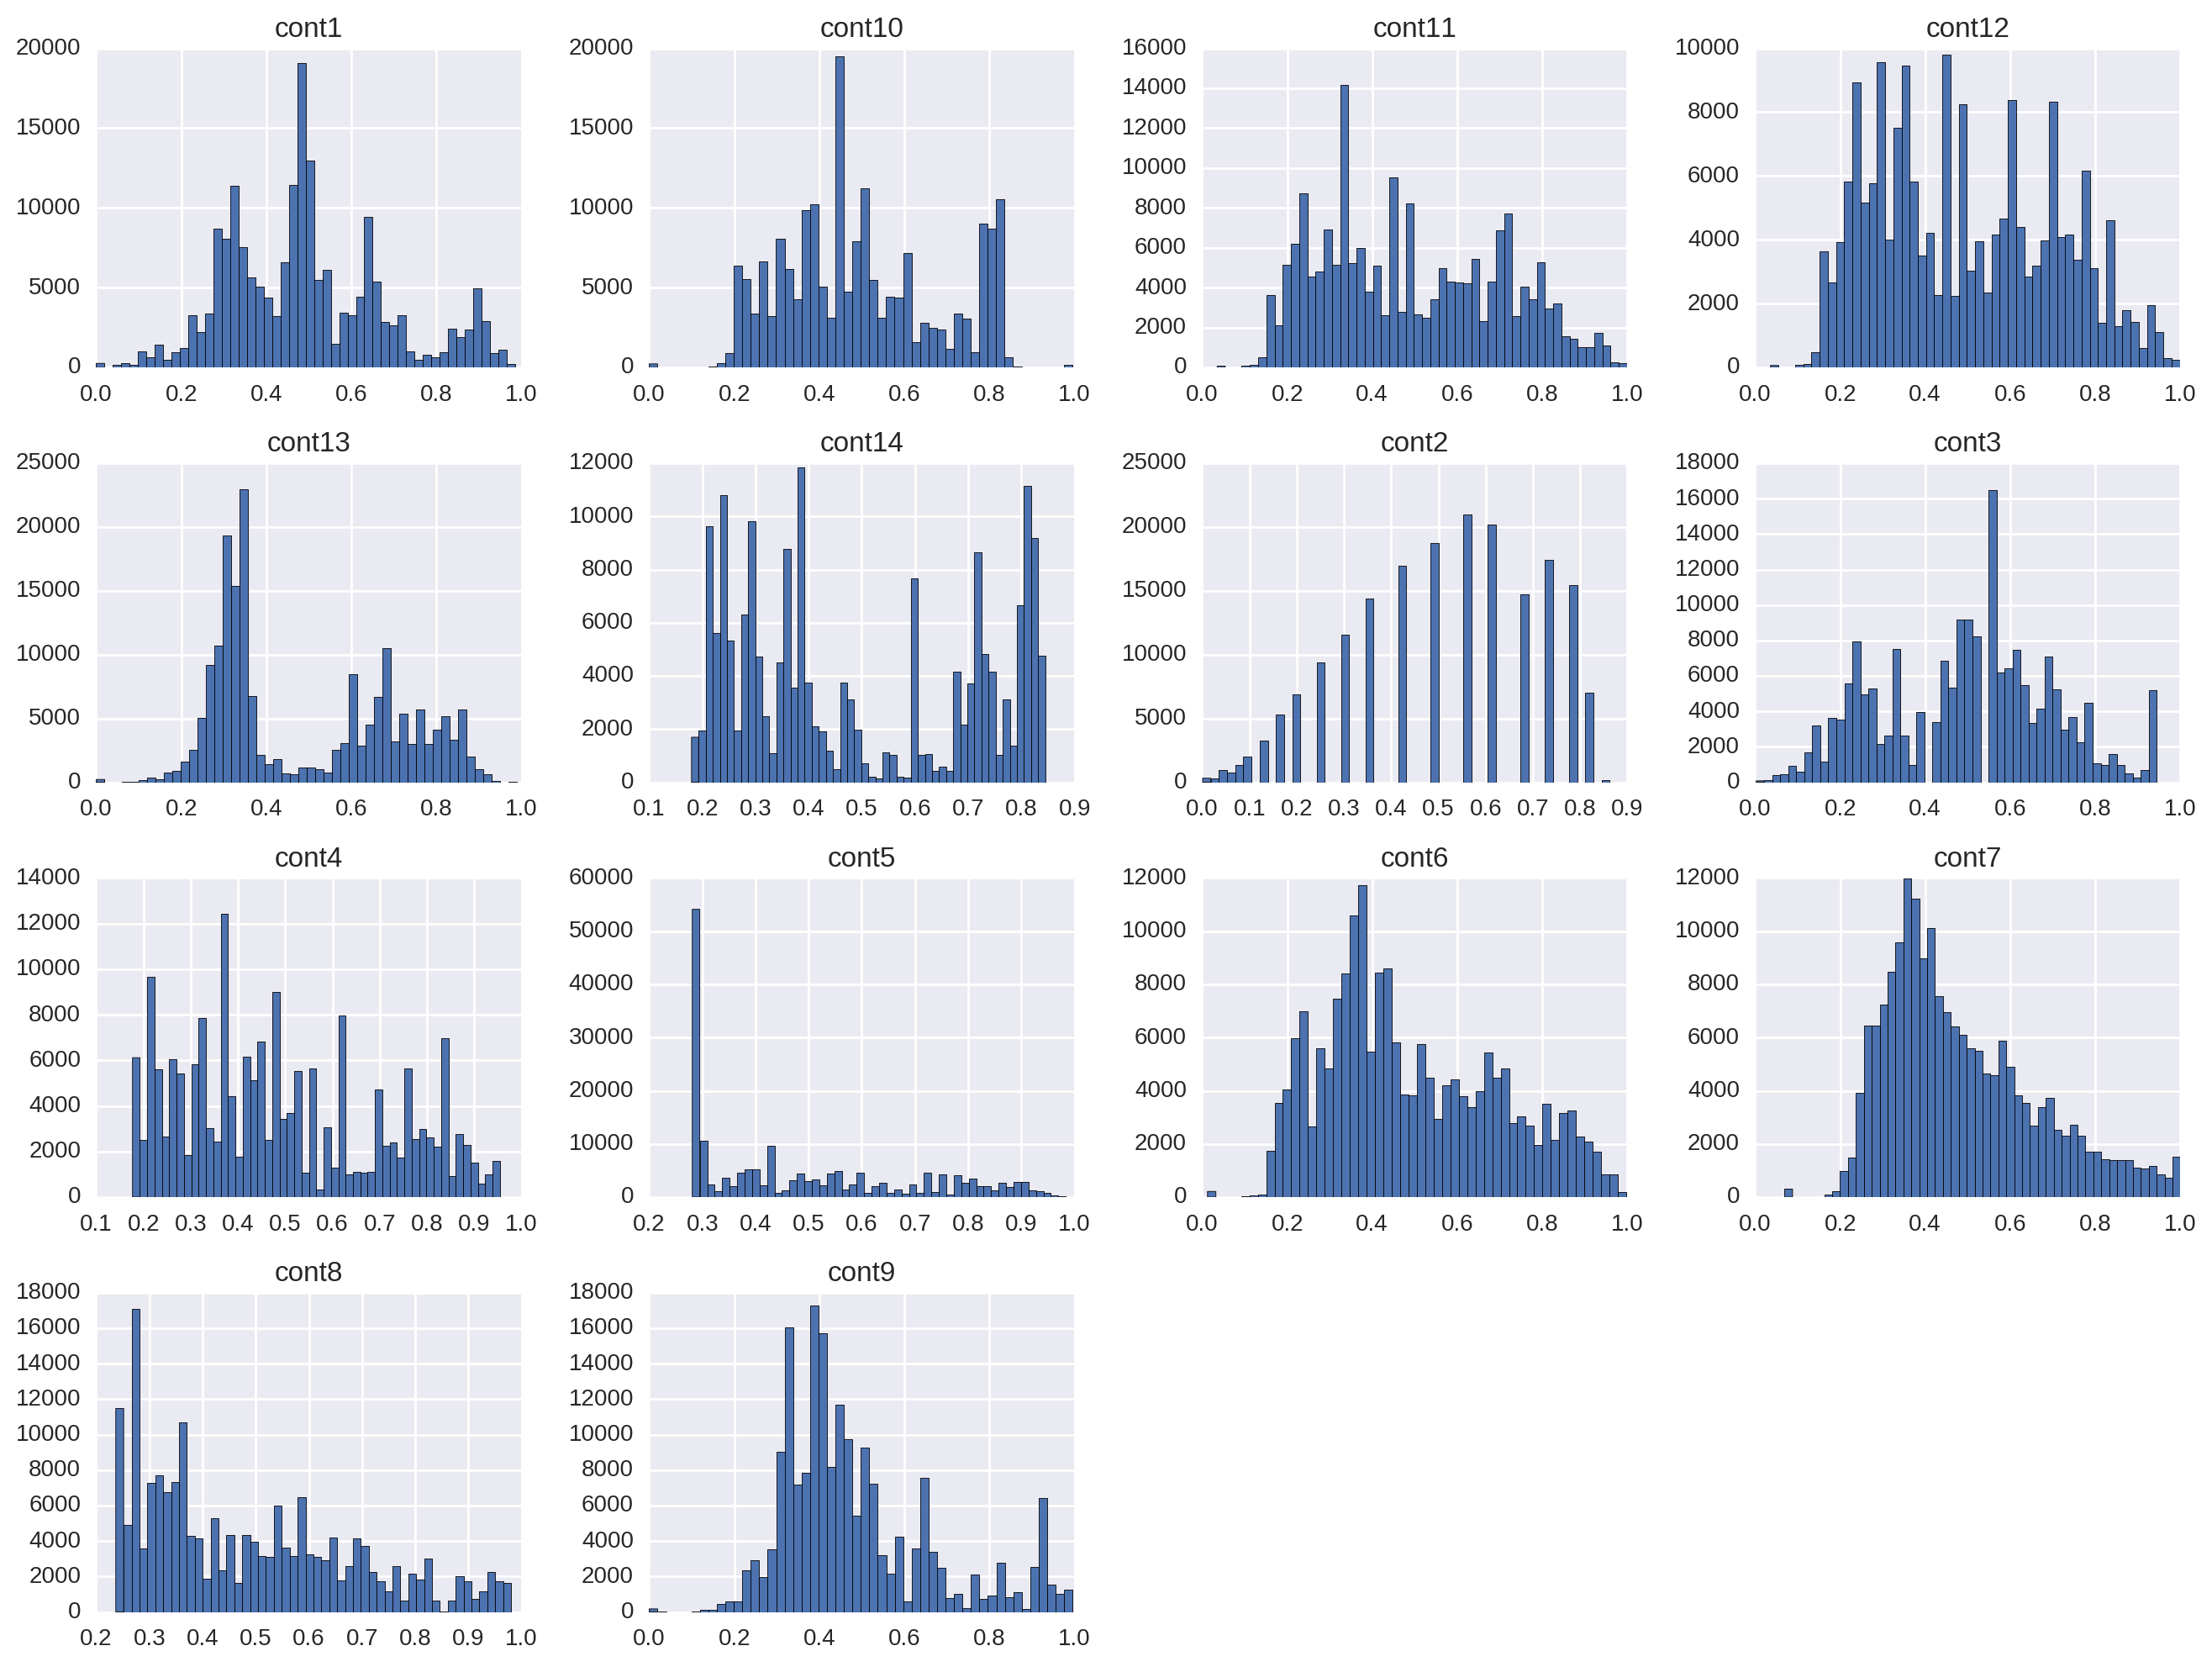

In [19]:
train[cont_features].hist(bins=50, figsize=(16,12))

### 特征之间的相关性

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


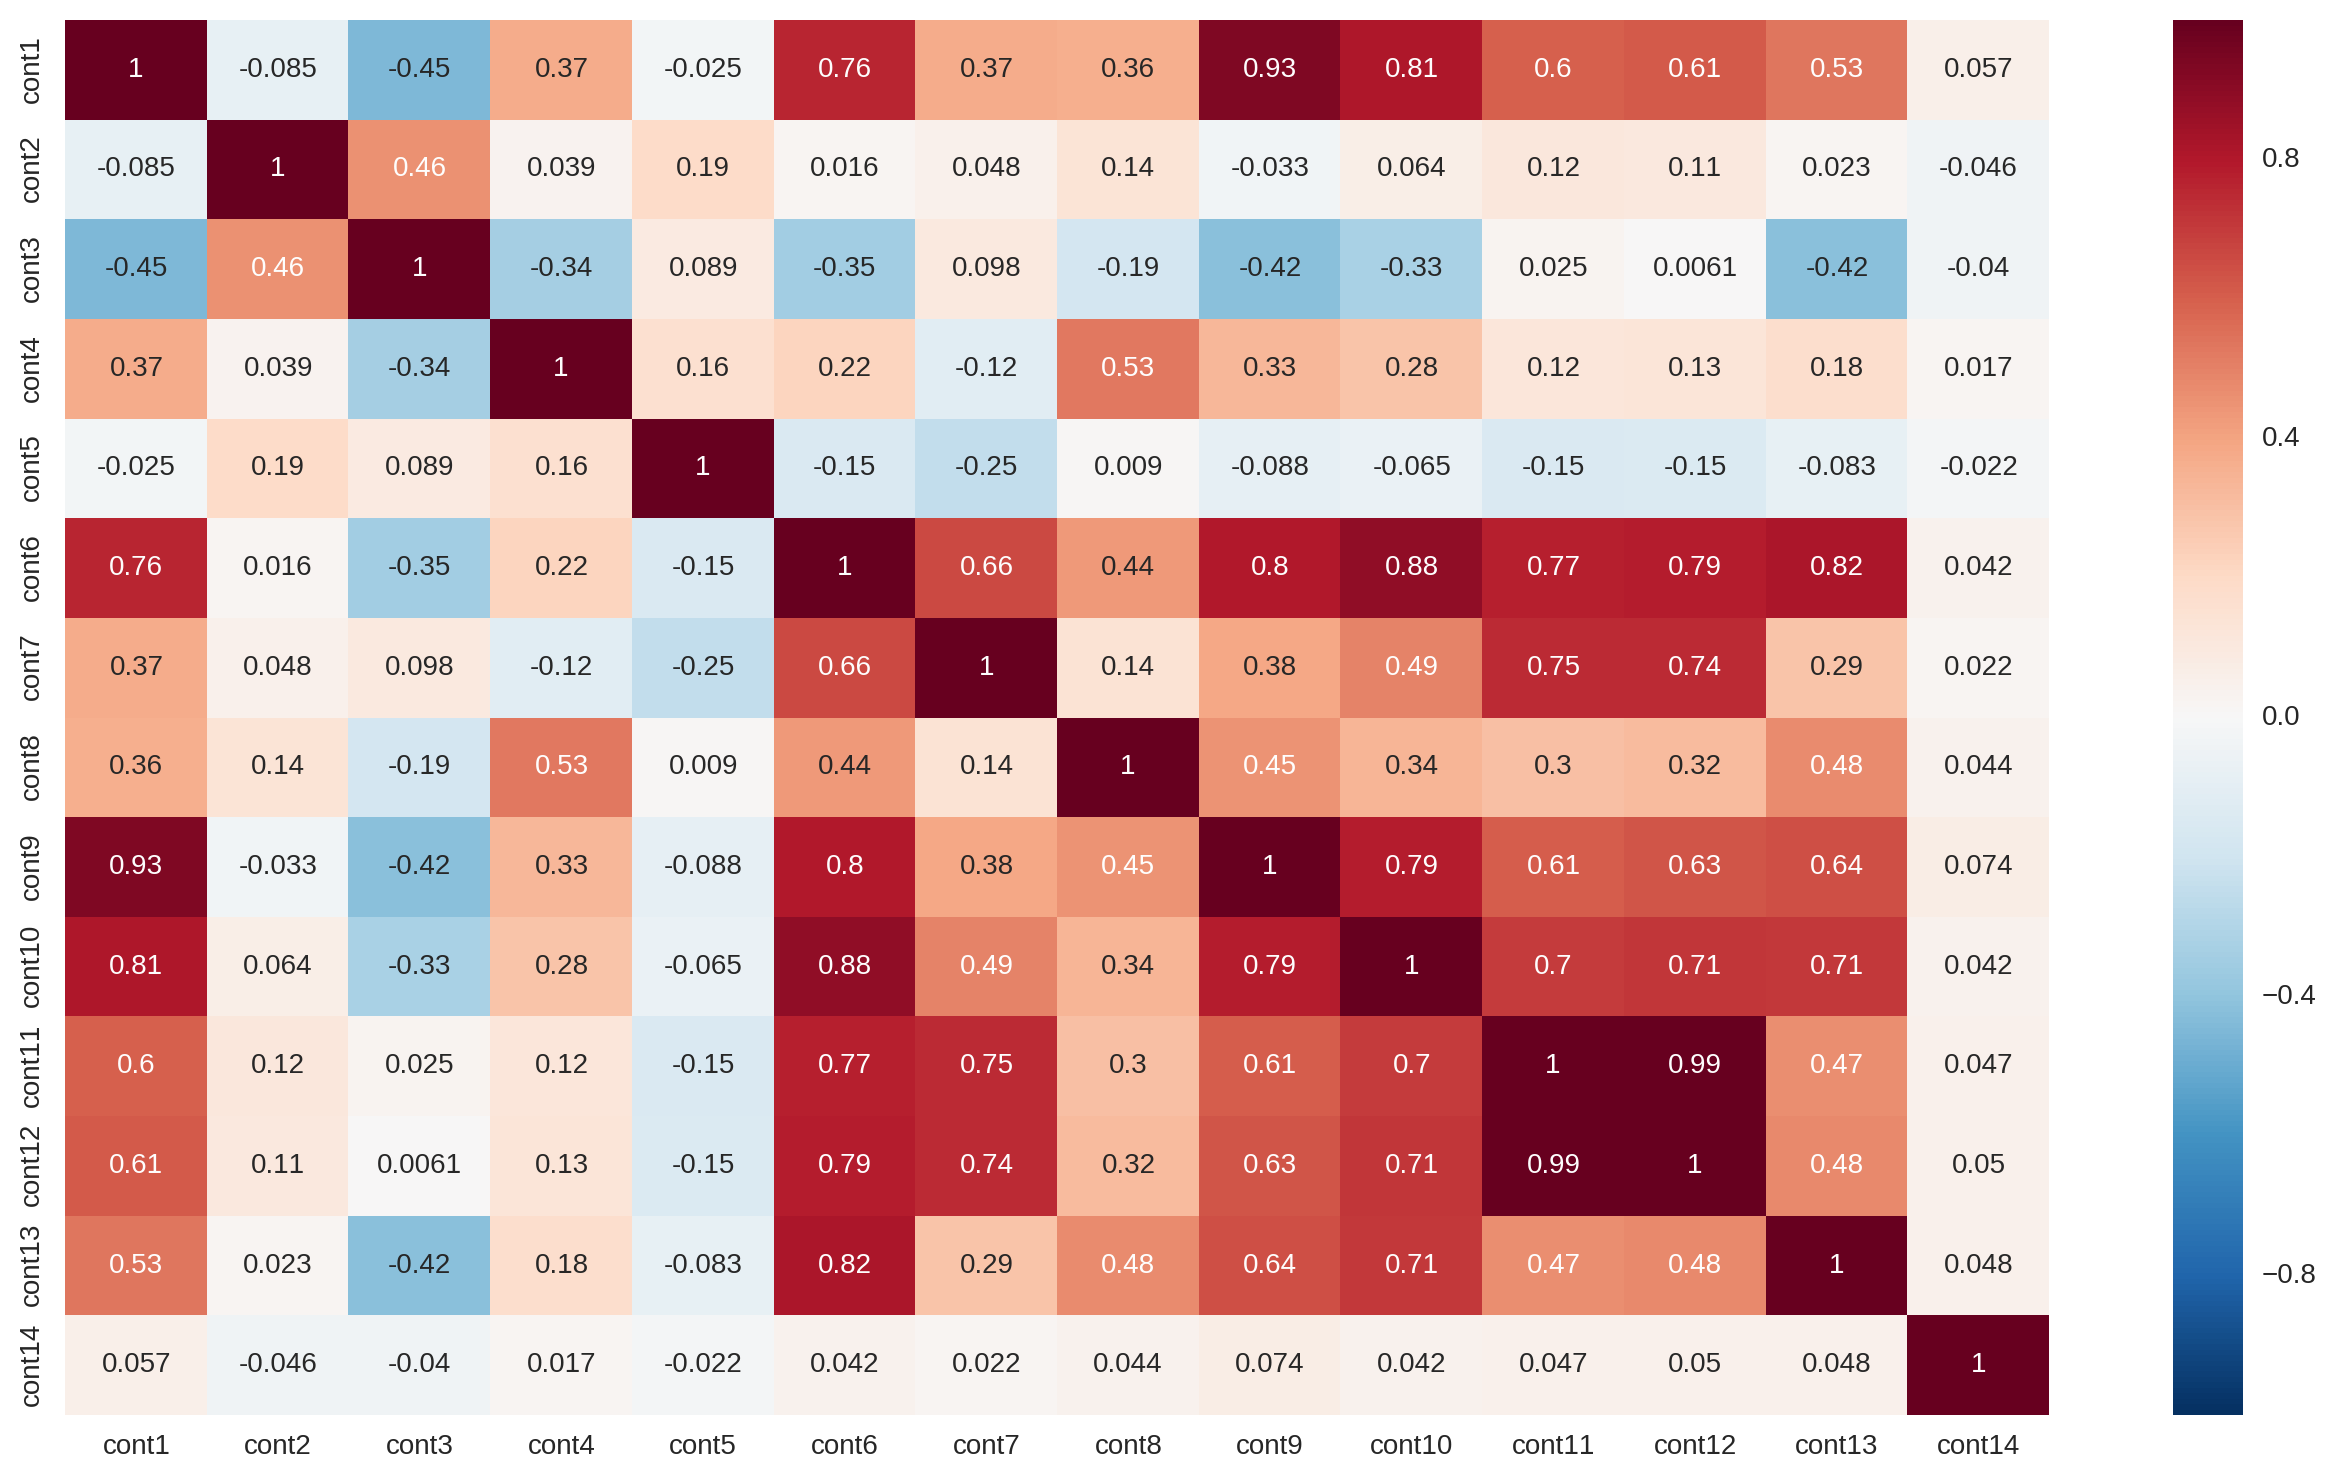

In [20]:
plt.subplots(figsize=(16,9))
correlation_mat = train[cont_features].corr()
sns.heatmap(correlation_mat, annot=True)

我们看到几个特征之间有很高的相关性